# How to recover a known planet in Kepler data?

This tutorial demonstrates the basic steps required to recover a transiting planet candidate in the Kepler data.

We will show how you can recover the signal of [Kepler-10b](https://en.wikipedia.org/wiki/Kepler-10b), the first rocky planet that was discovered by Kepler! Kepler-10 is a Sun-like (G-type) star approximately 600 light years away in the constellation of Cygnus. In this tutorial, we will download the pixel data of Kepler-10, extract a lightcurve, and recover the planet.

Kepler pixel data is distributed in  "Target Pixel Files". You can read more about them in our tutorial [here](http://lightkurve.keplerscience.org/tutorials/target-pixel-files.html). The `lightkurve` package provides a `KeplerTargetPixelFile` class, which enables you to load and interact with data in this format.

The class can take a path (local or url), or you can load data straight from the [MAST archive](https://archive.stsci.edu/kepler/), which holds all of the Kepler and K2 data archive. We'll download the Kepler-10 light curve using the `from_archive` function, as shown below. *(Note: we're adding the keyword `quarter=3` to download only the data from the third Kepler quarter. There were 17 quarters during the Kepler mission.)*

In [1]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive("Kepler-10", quarter=3)

Let's use the `plot` method and pass along an aperture mask and a few plotting arguments.

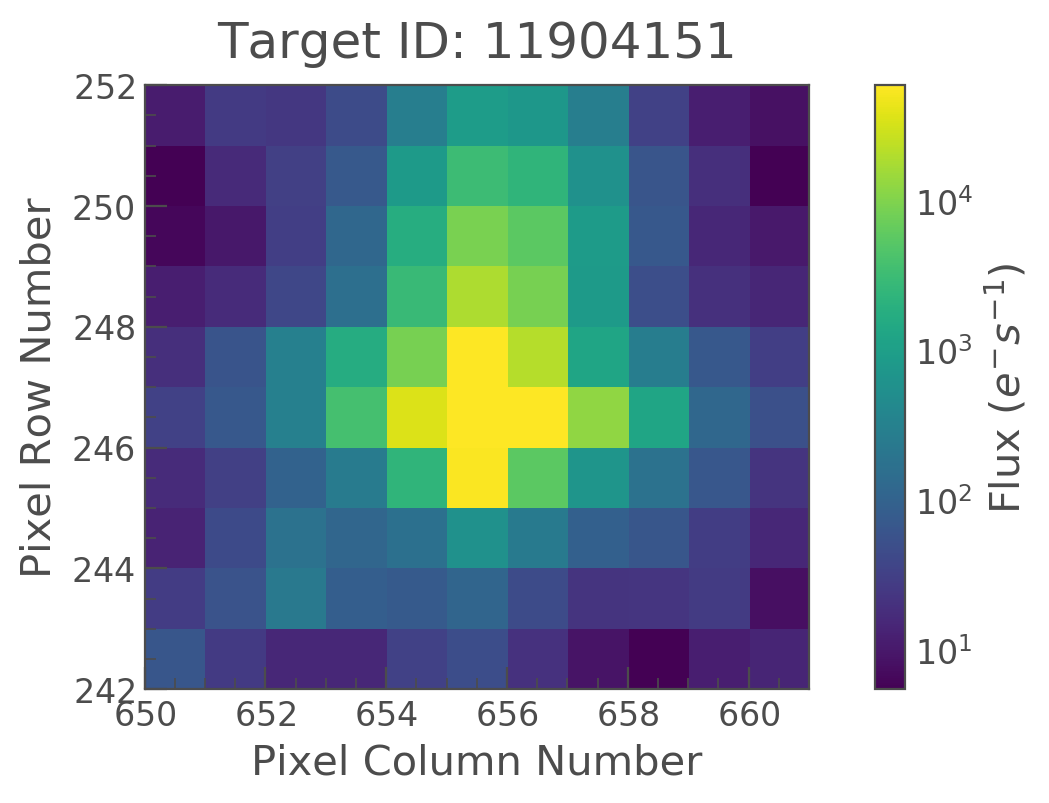

In [2]:
tpf.plot(scale='log');

The target pixel file contains one bright star with approximately 50,000 counts.

Now, we will use the ``to_lightcurve`` method to create a simple aperture photometry lightcurve using the
mask defined by the pipeline which is stored in `tpf.pipeline_mask`.

In [3]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

Let's take a look at the output lightcurve.

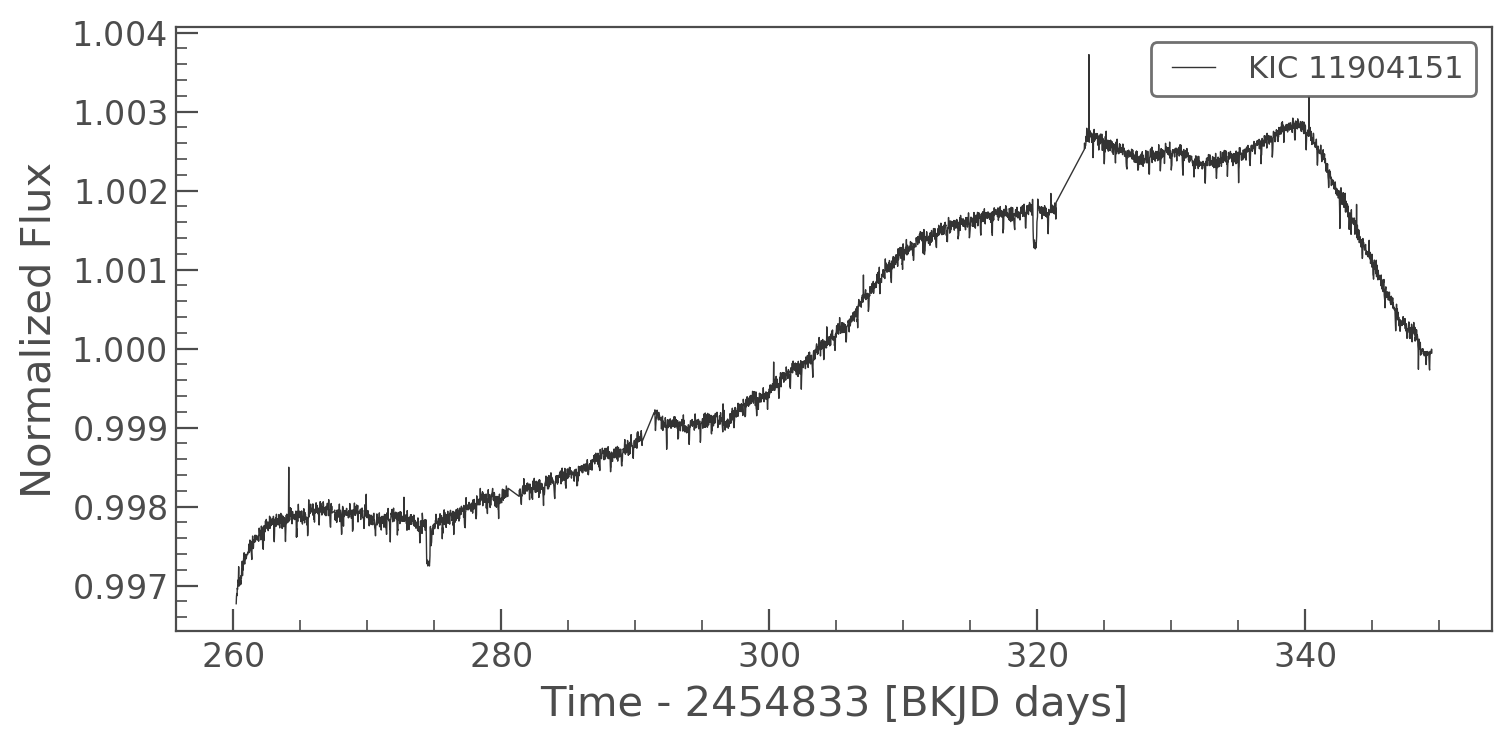

In [4]:
lc.plot();

Now let's use the `flatten` method, which applies a Savitzky-Golay filter, to remove long-term variability that we are not interested in. We'll use the `return_trend` keyword so that it returns both the corrected `KeplerLightCurve` object and a new `KeplerLightCurve` object called 'trend'. This contains only the long term variability.

In [5]:
flat, trend = lc.flatten(window_length=301, return_trend=True)

Let's plot the trend estimated by the Savitzky-Golay filter:

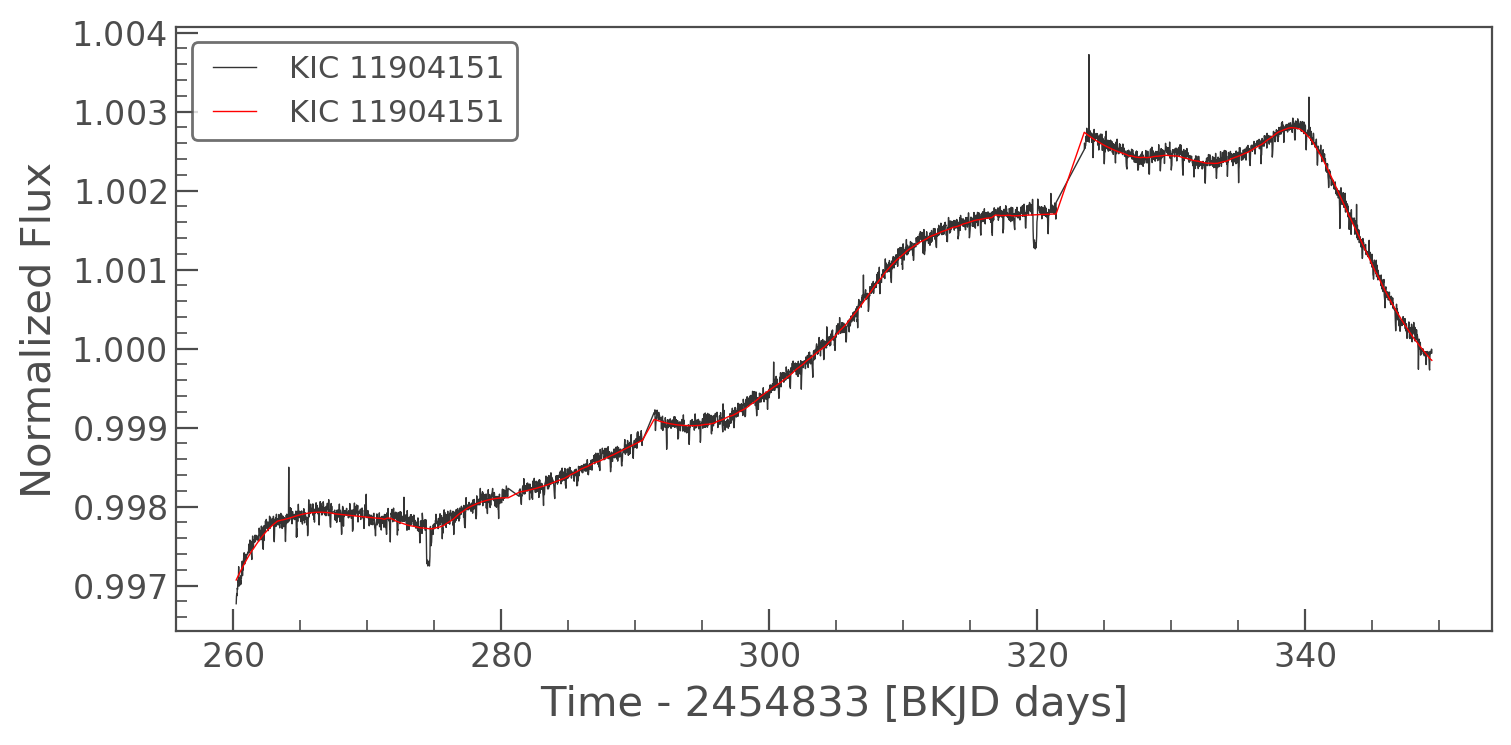

In [6]:
ax = lc.plot()                         #plot() returns a matplotlib axis 
trend.plot(ax=ax, color='red');           #which we can pass to the next plot() to use the same plotting window

and the flat lightcurve:

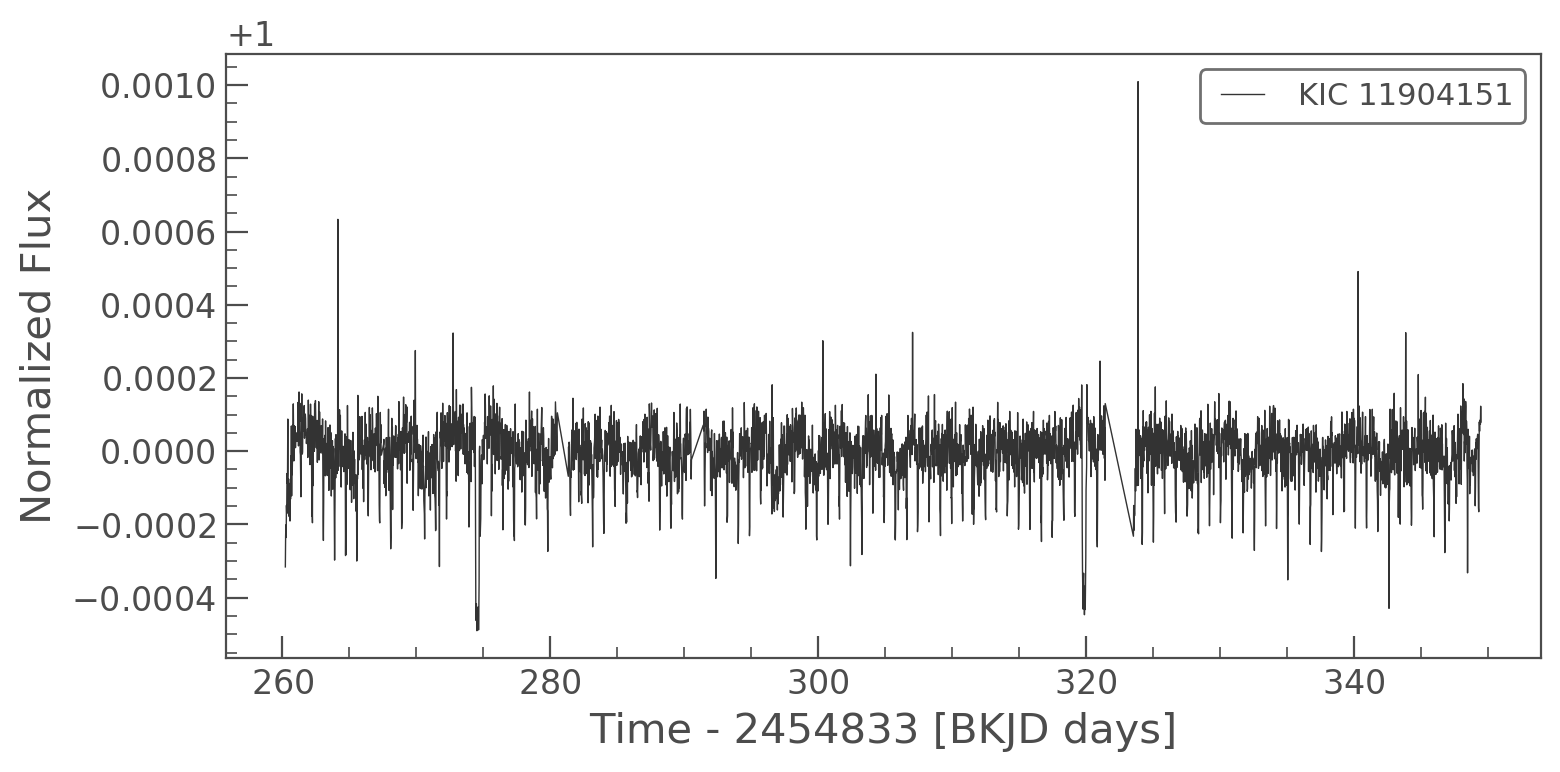

In [7]:
flat.plot();

Now, let's run a period search function using the Box-Least Squares algorithm (http://adsabs.harvard.edu/abs/2002A%26A...391..369K), which is available in the
latest dev version of astropy. 

`lightkurve` includes `bls` as a dependency, which is the package that `astropy.stats.bls` is built from. For now, let's use that.

In [15]:
from bls import BLS
import numpy as np
import matplotlib.pyplot as plt

We can create the durations and periods we want to sample with the BLS using numpy arrays. It looks like the planet has quite a short period, so let's limit the periods to between 0.6 and 1.2 days.

In [16]:
durations = np.linspace(0.001, 0.15, 20)
periods = np.linspace(0.6, 1.2, 30000)

Now we can setup the model, and find the power at each of those periods and durations. Power indicates how strong the periodic signal is at each point.

In [17]:
model = BLS(flat.time, flat.flux).power(periods, durations)

If we plot the power, we can see a strong feature in the power spectrum, indicating a periodicity.

Text(0.5,0,'Period [days]')

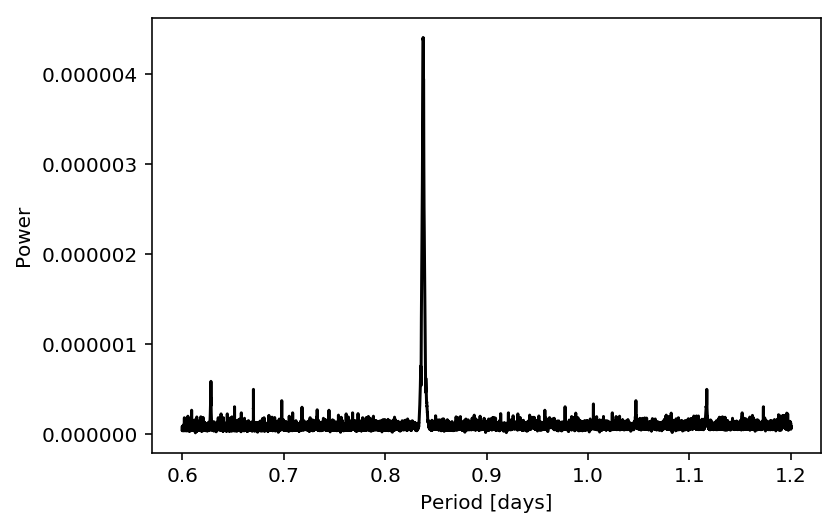

In [18]:
plt.plot(model.period, model.power, c='k');
plt.ylabel('Power')
plt.xlabel('Period [days]')

We can find the period of this signal using a simple `np.argmax`.

In [19]:
best_fit = model.period[np.argmax(model.power)]
print('Best Fit Period: {} days'.format(best_fit))

Best Fit Period: 0.8374879162638754 days


It looks like this planet has a period of $\approx$ 0.83 days. We can fold the light curve at that period to show the transit.

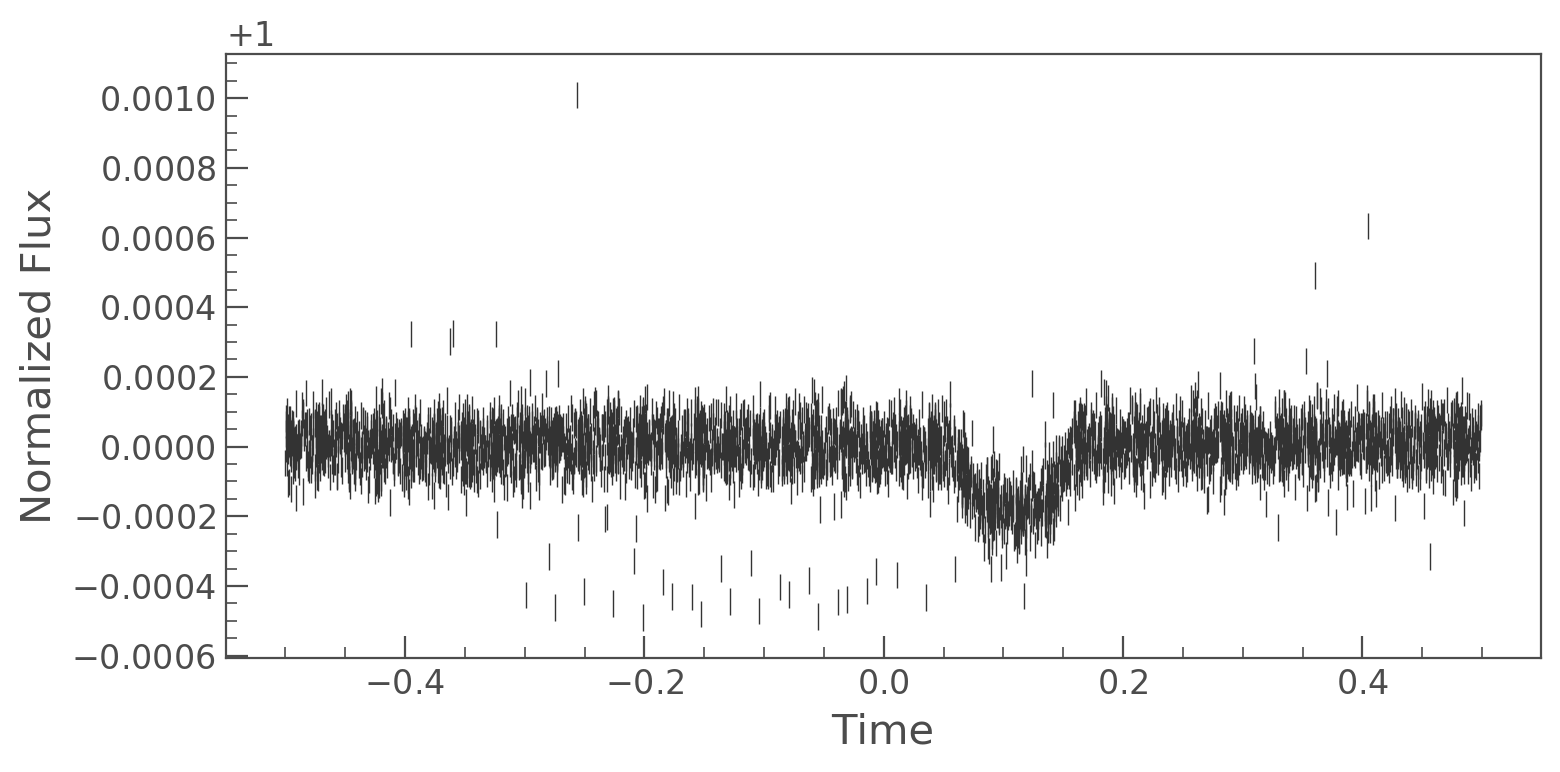

In [14]:
flat.fold(best_fit).errorbar();